### Setup environment

In [1]:
!pip install mediapy einops --quiet

In [2]:
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch
import mediapy as media
import torch.optim as optim


### Implementing building blocks for u-net

In [4]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.norm(x)
        x = self.gelu(x)
        return x

class FinalConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        return x

class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.norm(x)
        x = self.gelu(x)
        return x

class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convTrans(x)
        x = self.norm(x)
        x = self.gelu(x)
        return x


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.AvgPool2d(kernel_size = 7, stride = 7)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        x = self.gelu(x)
        return x


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.unflatten = nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 7, stride = 7, padding = 0)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.unflatten(x)
        x = self.gelu(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.gelu2 = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.norm(x)
        x = self.gelu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.gelu2(x)
        return x


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downConv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.gelu2 = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.downConv(x)
        x = self.norm(x)
        x = self.gelu(x)
        x = self.conv(x)
        x = self.norm2(x)
        x = self.gelu2(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.gelu2 = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upConv(x)
        x = self.norm(x)
        x = self.gelu(x)
        x = self.conv(x)
        x = self.norm2(x)
        x = self.gelu2(x)
        return x

### Gathering and ordering data

In [ ]:
train_dataset = MNIST(root='./data', train=True, transform=ToTensor(), download=True)
test_dataset = MNIST(root='./data', train=False, transform=ToTensor(), download=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.36MB/s]


In [ ]:
def noisingImage(img: torch.Tensor, noise_std: float) -> torch.Tensor:
    noisy_img = img + torch.randn_like(img) * noise_std
    noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())
    return noisy_img


In [ ]:
class PairedNoisyMNIST(Dataset):
    def __init__(self, original_dataset, noise_std):
        self.original_dataset = original_dataset
        self.noise_std = noise_std

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, label = self.original_dataset[idx]
        noisy_img = noisingImage(img, self.noise_std)
        return img, noisy_img, label

### Implementing an uconditioned UNet

In [5]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.fc1_t = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.fc2_t = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1_t(x)
        x = self.gelu(x)
        x = self.fc2_t(x)
        return x


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.convBlock1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, 2 * num_hiddens)
        self.flatten = Flatten()

        self.unflatten = Unflatten(2 * num_hiddens)
        self.fc1 = FCBlock(num_classes, 2 * num_hiddens)
        self.up1 = UpBlock(4 * num_hiddens, num_hiddens)
        self.fc2 = FCBlock(num_classes, num_hiddens)
        self.up2 = UpBlock(2 * num_hiddens, num_hiddens)
        self.convBlock2 = ConvBlock(2 * num_hiddens, num_hiddens)
        self.conv = FinalConv(num_hiddens, in_channels)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        t = t.float()
        x_conv1 = self.convBlock1(x)
        x_down1 = self.down1(x_conv1)
        x_down2 = self.down2(x_down1)
        x_flatten = self.flatten(x_down2)
        t_fc1 = self.fc1(t)
        # Reshape t_embedded to [batch_size, num_channels, 1, 1]
        t_fc1 = t_fc1.unsqueeze(-1).unsqueeze(-1)
        x_unflatten = self.unflatten(x_flatten) + t_fc1
        x = self.up1(torch.cat((x_unflatten, x_down2), dim=1))
        t_fc2 = self.fc2(t)
        t_fc2 = t_fc2.unsqueeze(-1).unsqueeze(-1)
        x = x + t_fc2
        x = self.up2(torch.cat((x, x_down1), dim=1))
        x = self.convBlock2(torch.cat((x, x_conv1), dim=1))
        x = self.conv(x)
        return x

### Implementing DDPM Forward and Inverse Process for unconditioned Denoising

In [6]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    b_list = torch.linspace(beta1, beta2, num_ts)
    a_list = 1 - b_list
    a_bar_list = torch.cumprod(a_list, dim=0)
    return {
        "betas": b_list,
        "alphas": a_list,
        "alpha_bars": a_bar_list,
    }

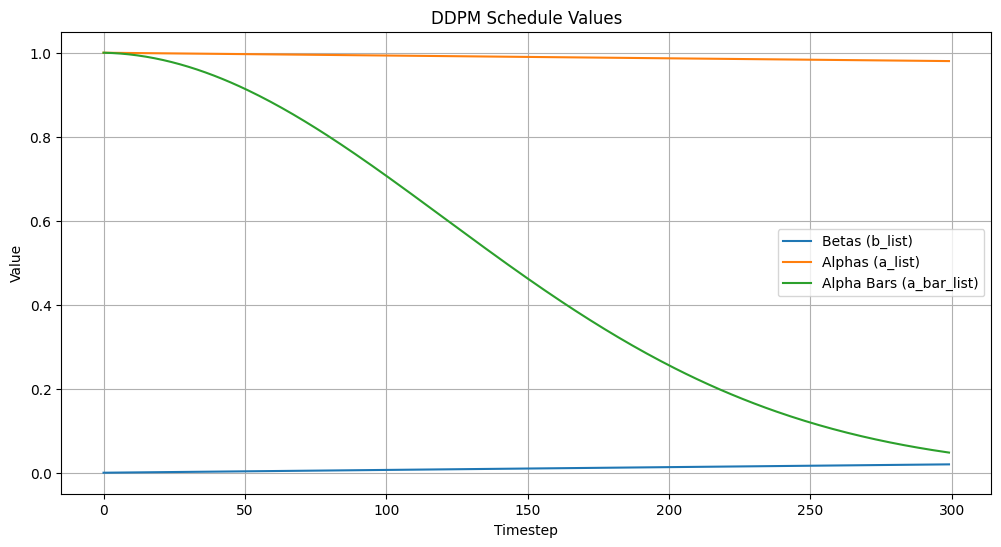

In [7]:
beta1 = 0.0001
beta2 = 0.02
num_ts = 300
schedule = ddpm_schedule(beta1, beta2, num_ts)

plt.figure(figsize=(12, 6))
plt.plot(schedule["betas"], label="Betas (b_list)")
plt.plot(schedule["alphas"], label="Alphas (a_list)")
plt.plot(schedule["alpha_bars"], label="Alpha Bars (a_bar_list)")
plt.title("DDPM Schedule Values")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import random

def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
    epochs: int = 5,
    batch_size: int = 128,
    lr: float = 1e-3,
    device: torch.device = torch.device("cuda")
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(unet.parameters(), lr=lr)
    gamma = 0.1**(1/epochs)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    train_loader = DataLoader(x_0, batch_size=batch_size, shuffle=True)
    unet.train()
    loss_history = []

    for i in range (epochs):
      for clean_images,_ in train_loader:
        clean_images = clean_images.to(device)
        timesteps = torch.randint(0, num_ts, (clean_images.size(0),), device=device).unsqueeze(1)
        epsilon = torch.randn_like(clean_images)
        a_bar = ddpm_schedule['alpha_bars'].to(device)[timesteps].view(-1, 1, 1, 1)

        noisy_versions = torch.sqrt(a_bar)*clean_images + torch.sqrt(1-a_bar)*epsilon
        outputs = unet(noisy_versions, timesteps.float() / num_ts)

        loss = criterion(outputs, epsilon)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

      scheduler.step()
    return loss_history


In [9]:
import torch
import time
import gc

def print_gpu_stats(stage=""):
    alloc = torch.cuda.memory_allocated() / 2**20
    reserv = torch.cuda.memory_reserved() / 2**20
    peak = torch.cuda.max_memory_allocated() / 2**20
    print(f"[{stage}] allocated={alloc:.1f}MiB reserved={reserv:.1f}MiB peak={peak:.1f}MiB")

print_gpu_stats("Before model init")



[Before model init] allocated=0.0MiB reserved=0.0MiB peak=0.0MiB


### Train the unconditional unet according to the DDPM paper for 5 epochs

In [ ]:
betas = (1e-4, 0.02)
num_ts = 300

schedule = ddpm_schedule(betas[0], betas[1], num_ts)


unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to('cuda')
device = torch.device("cuda")

loss_history = ddpm_forward(
    unet=unet,
    ddpm_schedule=schedule,
    x_0=train_dataset,
    num_ts=300,
    epochs=10,
    batch_size=128,
    lr=1e-3,
    device=device
)

KeyboardInterrupt: 

In [ ]:
print(loss_history[-10:])

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, linestyle='-', label='Training Loss', linewidth=2)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss History (Logarithmic Scale)')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # Grid with less intrusive lines
plt.show()

In [ ]:
torch.save(unet.state_dict(), "unconditioned_unet_5_epochs.pth")
from google.colab import files
files.download("unconditioned_unet_5_epochs.pth")

### Import weights for pre-trained unconditional unet (instead of training from scratch above)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving unet_ddpm_mnist.pth to unet_ddpm_mnist.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to(device)
unet.load_state_dict(torch.load("unconditioned_unet_5_epochs.pth"))

#If working outside of colab, you can load the model weights from a local file:
#unet.load_state_dict(torch.load("Weights/unconditioned_unet_5_epochs.pth"))


/var/folders/48/8nktzv4972x0w676hvrsryhm0000gn/T/ipykernel_37199/2391390648.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load("Weights/unet

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### Sampling and plotting functions

In [ ]:
def plot_image(img, step):
    """Helper function to plot the current image at a given timestep."""
    img = img.squeeze().cpu().clamp(0, 1)  # Remove batch and channel dim
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Timestep: {step}")
    plt.show()

In [ ]:
@torch.inference_mode()
def ddpm_sample_batch(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
    batch_size: int = 1,
) -> torch.Tensor:

    unet.eval()
    torch.manual_seed(seed)
    img = torch.randn(batch_size, 1, img_wh[0], img_wh[1], device=device)

    alphas = ddpm_schedule["alphas"].to(device)
    betas = ddpm_schedule["betas"].to(device)
    alpha_bars = ddpm_schedule["alpha_bars"].to(device)

    for t in reversed(range(1, num_ts)):
        t_tensor = torch.full((batch_size, 1), t, device=device).float() / num_ts
        alpha_bar_t = alpha_bars[t].view(1, 1, 1, 1)
        alpha_bar_t_minus1 = alpha_bars[t - 1].view(1, 1, 1, 1)
        beta_t = betas[t].view(1, 1, 1, 1)
        alpha_t = alphas[t].view(1, 1, 1, 1)

        epsilon_theta = unet(img, t_tensor)

        x0_hat = (1 / torch.sqrt(alpha_bar_t)) * (img - torch.sqrt(1 - alpha_bar_t) * epsilon_theta)

        noise = torch.randn_like(img) if t > 1 else torch.zeros_like(img)
        img = (
            (torch.sqrt(alpha_bar_t_minus1) * beta_t / (1 - alpha_bar_t)) * x0_hat +
            (torch.sqrt(alpha_t) * (1 - alpha_bar_t_minus1) / (1 - alpha_bar_t)) * img +
            torch.sqrt(beta_t) * noise
        )

    return img


In [ ]:


def ddpm_sample_batch_grad(unet, schedule, img_wh, num_ts, batch_size, seed):
    torch.manual_seed(seed)
    img = torch.randn(batch_size, 1, img_wh[0], img_wh[1], device=device, requires_grad=True)

    alphas     = schedule["alphas"].to(device)
    betas      = schedule["betas"].to(device)
    alpha_bars = schedule["alpha_bars"].to(device)

    for t in reversed(range(1, num_ts)):
        # batch of timestep fractions [B,1]
        t_frac = torch.full((batch_size,1), float(t)/num_ts, device=device)
        α_t    = alphas[t].view(1,1,1,1)
        β_t    = betas[t].view(1,1,1,1)
        α_bar  = alpha_bars[t].view(1,1,1,1)
        α_bar1 = alpha_bars[t-1].view(1,1,1,1)

        εθ = unet(img, t_frac)  # [B,1,H,W]
        x0 = (img - (1-α_bar).sqrt()*εθ) / α_bar.sqrt()
        noise = torch.randn_like(img) if t>1 else torch.zeros_like(img)

        img = (α_bar1.sqrt()*β_t/(1-α_bar))*x0 \
              + (α_t.sqrt()*(1-α_bar1)/(1-α_bar))*img \
              + β_t.sqrt()*noise
        img.requires_grad_(True)

    return img


In [ ]:
import torch
import matplotlib.pyplot as plt

def generate_and_plot_ddpm_samples(
    unet,
    ddpm_schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=8,
    title="DDPM samples"
):

    samples = ddpm_sample_batch(
        unet=unet,
        ddpm_schedule=ddpm_schedule,
        img_wh=img_wh,
        num_ts=num_ts,
        seed=seed,
        batch_size=batch_size
    )

    samples = samples.cpu().detach()
    samples = samples.clamp(0, 1)

    # Plot
    num_rows = (batch_size + num_cols - 1) // num_cols
    plt.figure(figsize=(num_cols * 1.5, num_rows * 1.5))

    for i in range(min(batch_size, samples.size(0))):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(samples[i, 0], cmap='gray')
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


### Loading the discriminator

In [ ]:
import torch
def prepare_batch_discr(batch: torch.Tensor) -> torch.Tensor:
    assert isinstance(batch, torch.Tensor) and batch.ndim == 4, "Input must be [N,C,H,W] tensor"
    batch = batch.clamp(0.0, 1.0)
    return batch * 2.0 - 1.0


In [ ]:
import torch
import torch.nn as nn
import urllib.request

class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            return nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        return self.main(input).view(-1, 1).squeeze(1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


url = "https://github.com/csinva/gan-vae-pretrained-pytorch/raw/master/mnist_dcgan/weights/netD_epoch_99.pth"
torch.hub.download_url_to_file(url, 'netD_epoch_99.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netD = Discriminator(ngpu=1).to(device)
netD.load_state_dict(torch.load('netD_epoch_99.pth', map_location=device))
netD.eval()


100%|██████████| 2.53M/2.53M [00:00<00:00, 90.6MB/s]


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [ ]:
print_gpu_stats("After diffusion training and loading discriminator")

[After diffusion training and loading discriminator] allocated=22.5MiB reserved=642.0MiB peak=541.0MiB


### Adding time as input to the discriminator, basic method

In [ ]:
import torch
import torch.nn as nn
import urllib.request

class TimeConditionedDiscriminator(nn.Module):
    def __init__(self, ngpu, nc=1, ndf=64):
        super(TimeConditionedDiscriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc+1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, t):
        B, _, H, W = x.shape
        t = t.view(B, 1, 1, 1).expand(B, 1, H, W)
        xt = torch.cat([x, t], dim=1)
        return self.main(xt).view(-1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
import torch
import torch.nn as nn
import urllib.request

# --- Define the architecture ---
class TimeConditionedDiscriminatorComplex(nn.Module):
    def __init__(self, ngpu, nc=1, ndf=64):
        super(TimeConditionedDiscriminatorComplex, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(2,    64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64,  128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 3, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512,   1, 1, 1, 0),   # kernel=4, stride=1, no padding
            nn.Sigmoid()
        )

    def forward(self, x, t):
        B, _, H, W = x.shape
        t = t.view(B, 1, 1, 1).expand(B, 1, H, W)
        xt = torch.cat([x, t], dim=1)
        return self.main(xt).view(-1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Testing the discriminator without fine-tuning

In [ ]:
unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to('cuda')
unet.load_state_dict(torch.load("unconditioned_unet_5_epochs.pth"))

samples = ddpm_sample_batch(
  unet=unet,
  ddpm_schedule=schedule,
  img_wh=(28, 28),
  num_ts=300,
  batch_size=300,
  seed = 1
)

resized_samples = prepare_batch_discr(samples)
mnist = train_dataset
loader = DataLoader(mnist, batch_size=300, shuffle=True)
images, labels = next(iter(loader))
resized_mnist = prepare_batch_discr(images)



In [ ]:
real_imgs = resized_mnist.to(device)
fake_imgs = resized_samples.to(device)

with torch.no_grad():
    real_scores = netD(real_imgs)    # expected to be close to 1
    fake_scores = netD(fake_imgs)    # expected to be close to 0
    print(f"real_scores shape: {real_scores.shape}")
    print(f"fake_scores shape: {fake_scores.shape}")


print(f"Average score for real MNIST: {real_scores.mean().item():.4f}")
print(f"Average score for DDPM samples: {fake_scores.mean().item():.4f}")


real_scores shape: torch.Size([300])
fake_scores shape: torch.Size([300])
Average score for real MNIST: 0.6081
Average score for DDPM samples: 0.1835


### Plotting images before any finetuning

In [ ]:
unet_dif_only = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to('cuda')
unet_dif_only.load_state_dict(torch.load("unconditioned_unet_5_epochs.pth"))

<All keys matched successfully>

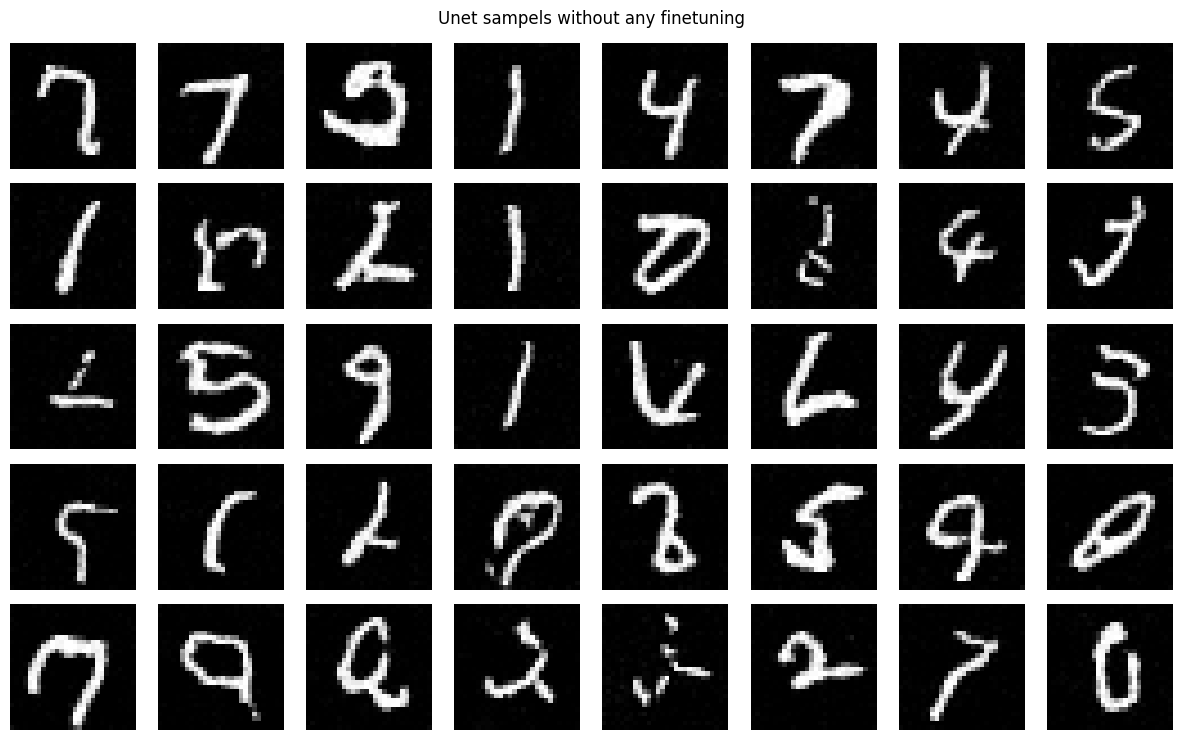

In [ ]:

generate_and_plot_ddpm_samples(
    unet=unet_dif_only,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=2,
    batch_size=40,
    num_cols=8,
    title="Unet sampels without any finetuning"
)

In [ ]:
print_gpu_stats("After diffusion training and loading discriminator")

[After diffusion training and loading discriminator] allocated=26.7MiB reserved=1084.0MiB peak=731.7MiB


### Fine-tuning the diffusion model after all denoising iterations, leaving discriminator as is

In [ ]:
num_iter  = 10
batch_size  = 10
lr          = 1e-4
num_timesteps = 300
seed_offset = 1


optimizer = optim.Adam(unet_dif_only.parameters(), lr=lr)
bce       = nn.BCELoss()

loss_history = []

netD.eval()
for p in netD.parameters():
    p.requires_grad_(False)

for i in range(num_iter):

    fake = ddpm_sample_batch_grad(
        unet     = unet_dif_only,
        schedule = schedule,
        img_wh   = (28, 28),
        num_ts   = num_timesteps,
        batch_size = batch_size,
        seed     = seed_offset + i
    )

    fake = prepare_batch_discr(fake)

    pred = netD(fake)
    print(f'Average predictor score on {batch_size} images:{pred.mean().item():.4f}')

    labels_real = torch.ones_like(pred)
    adv_loss  = bce(pred, labels_real)

    optimizer.zero_grad(set_to_none=True)
    adv_loss.backward()
    optimizer.step()


    loss = adv_loss.item()
    print(f'loss: {loss}')
    loss_history.append(loss)
    del fake, pred, labels_real, adv_loss


Average predictor score on 10 images:0.2083
loss: 4.3286004066467285
Average predictor score on 10 images:0.1832
loss: 5.329022407531738
Average predictor score on 10 images:0.0370
loss: 5.733564853668213
Average predictor score on 10 images:0.1226
loss: 4.084567546844482
Average predictor score on 10 images:0.1271
loss: 2.818574905395508
Average predictor score on 10 images:0.2293
loss: 2.398672342300415
Average predictor score on 10 images:0.1659
loss: 2.8696582317352295
Average predictor score on 10 images:0.1504
loss: 3.382864475250244
Average predictor score on 10 images:0.1622
loss: 2.754730463027954
Average predictor score on 10 images:0.3081
loss: 1.6262285709381104


In [ ]:
print_gpu_stats("After fine-tuning")

[After fine-tuning] allocated=46.3MiB reserved=14054.0MiB peak=13936.2MiB


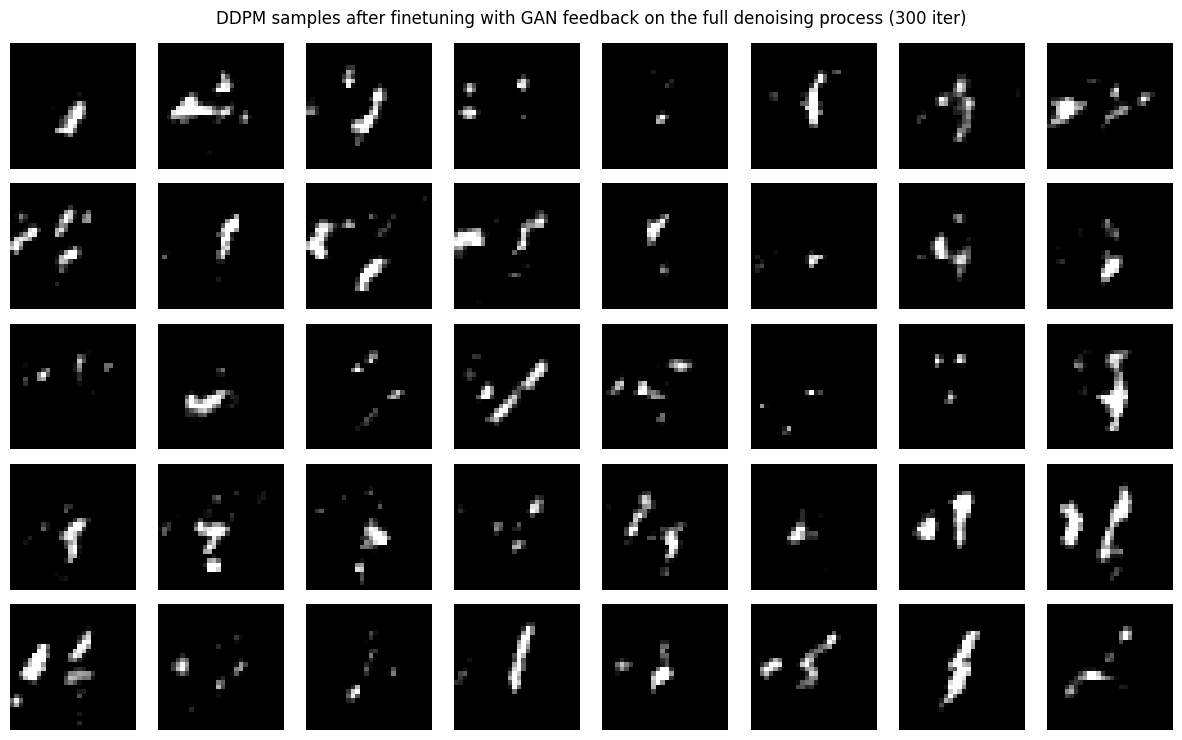

In [ ]:
generate_and_plot_ddpm_samples(
    unet=unet_dif_only,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=8,
    title="DDPM samples after finetuning with GAN feedback on the full denoising process (300 iter)"
)

### Fine-tuning the diffusion model and the discriminator simultaneously after all denoising iterations

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

unet_ft_dif_and_disc = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to('cuda')
unet_ft_dif_and_disc.load_state_dict(torch.load("unconditioned_unet_5_epochs.pth"))

netD_ft_dif_and_disc  = Discriminator(ngpu=1).to(device)
netD_ft_dif_and_disc.load_state_dict(torch.load('netD_epoch_99.pth', map_location=device))

betas = (1e-4, 0.02)
num_ts = 300

schedule = ddpm_schedule(betas[0], betas[1], num_ts)
device = torch.device("cuda")

mnist = MNIST(root="./data", train=True, download=True, transform=ToTensor())
real_loader = DataLoader(mnist, batch_size=10, shuffle=True)

optD = optim.Adam(netD_ft_dif_and_disc.parameters(), lr=1e-5, betas=(0.5, 0.999))
optG = optim.Adam(unet_ft_dif_and_disc.parameters(), lr=1e-5, betas=(0.5, 0.999))

bce = nn.BCELoss()
mse = nn.MSELoss()

num_iters = 50

real_iter = iter(real_loader)

batch_size = 10
for it in range(num_iters):
    netD_ft_dif_and_disc.train()
    for p in unet_ft_dif_and_disc.parameters():
      p.requires_grad_(False)
    for p in netD_ft_dif_and_disc.parameters():
      p.requires_grad_(True)

    unet_ft_dif_and_disc.train()

    try:
        x_real, _ = next(real_iter)
    except StopIteration:
        real_iter = iter(real_loader)
        x_real, _ = next(real_iter)
    x_real = prepare_batch_discr(x_real).to(device)
    with torch.no_grad():
        x_fake = ddpm_sample_batch(
            unet      = unet_ft_dif_and_disc,
            ddpm_schedule  = schedule,
            img_wh    = (28, 28),
            num_ts    = 300,
            seed      = it,
            batch_size= batch_size

        )
    x_fake = prepare_batch_discr(x_fake)

    d_real = netD_ft_dif_and_disc(x_real)
    d_fake = netD_ft_dif_and_disc(x_fake)
    print(f'd_real: {d_real.mean().item():.4f}, d_fake: {d_fake.mean().item():.4f}')

    lossD = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
    optD.zero_grad()
    lossD.backward()
    optD.step()

    del x_real, d_real, d_fake

    for p in unet_ft_dif_and_disc.parameters():
      p.requires_grad_(True)
    for p in netD_ft_dif_and_disc.parameters():
      p.requires_grad_(False)

    netD_ft_dif_and_disc.train()
    unet_ft_dif_and_disc.train()
    x_fake2 = ddpm_sample_batch_grad(
        unet      = unet_ft_dif_and_disc,
        schedule  = schedule,
        img_wh    = (28, 28),
        num_ts    = 300,
        batch_size= batch_size,
        seed      = it,
    )
    x_fake2 = prepare_batch_discr(x_fake2)
    predG = netD_ft_dif_and_disc(x_fake2)
    lossG = bce(predG, torch.ones_like(predG))
    print(f'd_fake nr 2: {predG.mean().item():.4f}')

    optG.zero_grad()
    lossG.backward()
    optG.step()

    print(f'lossD: {lossD.item():.4f}, lossG: {lossG.item():.4f}')

    del x_fake2, predG, lossG, lossD, x_fake


d_real: 0.9753, d_fake: 0.0001
d_fake nr 2: 0.0000 test pred: 0.0001
lossD: 0.0256, lossG: 14.4972
d_real: 0.6460, d_fake: 0.0012
d_fake nr 2: 0.0000 test pred: 0.0013
lossD: 0.6712, lossG: 13.1921
d_real: 0.8590, d_fake: 0.0001
d_fake nr 2: 0.0000 test pred: 0.0001
lossD: 0.1637, lossG: 15.9113
d_real: 0.8259, d_fake: 0.0000
d_fake nr 2: 0.0000 test pred: 0.0000
lossD: 0.2049, lossG: 13.8482
d_real: 0.9932, d_fake: 0.0020
d_fake nr 2: 0.0000 test pred: 0.0020
lossD: 0.0089, lossG: 12.3015
d_real: 0.8941, d_fake: 0.0001


KeyboardInterrupt: 

In [ ]:
print_gpu_stats("After fine-tuning")

[After fine-tuning] allocated=80.3MiB reserved=14062.0MiB peak=13931.3MiB


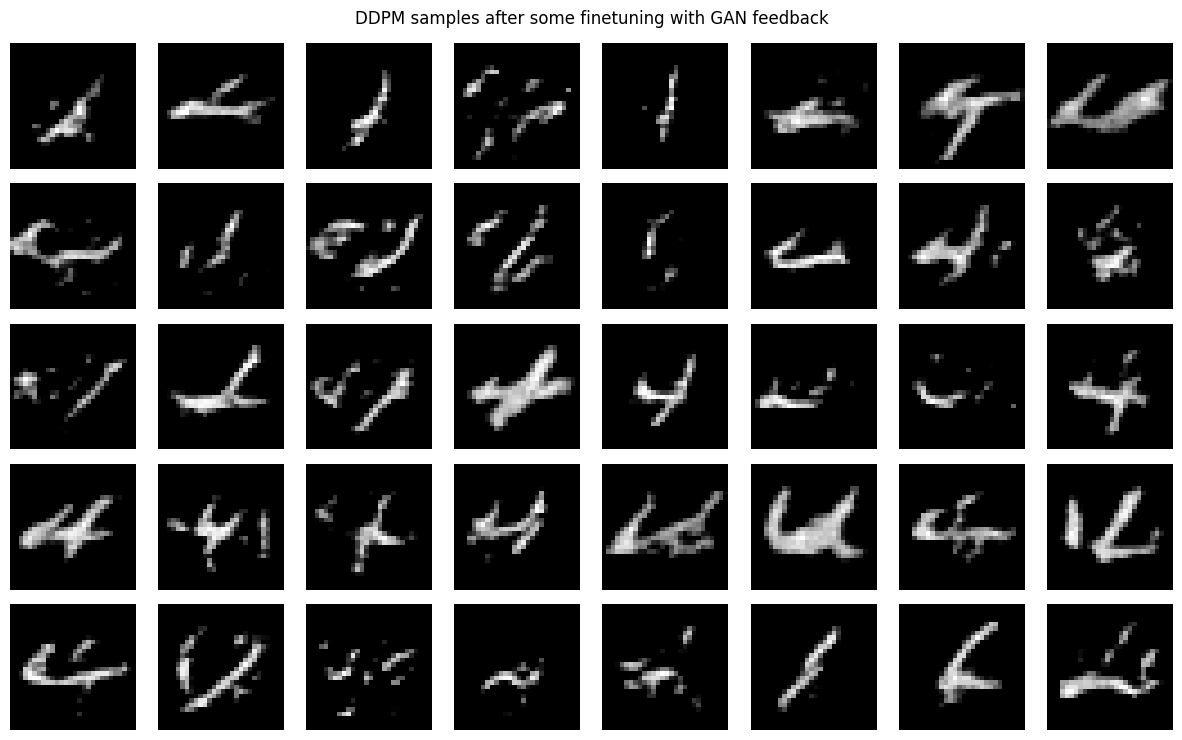

In [ ]:
generate_and_plot_ddpm_samples(
    unet=unet_ft_dif_and_disc,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=8,
    title="DDPM samples after some finetuning with GAN feedback"
)

### Fine-tune diffusion model, train discriminator from scratch, both on noise.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

beta_start = 1e-4
beta_end   = 0.02
num_timesteps = 300
batch_size    = 128
epochs        = 20
lr_d          = 1e-4
lr_g          = 1e-5
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

schedule = ddpm_schedule(beta_start, beta_end, num_timesteps)

unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to(device)
unet.load_state_dict(torch.load("unconditioned_unet_5_epochs.pth"))
discriminator = Discriminator(ngpu=1, nc=1, ndf=64).to(device)
#discriminator.apply(weights_init)


optD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
optG = optim.Adam(unet.parameters(), lr=lr_g, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()

mnist = MNIST(root="./data", train=True, download=True, transform=ToTensor())
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=4)


for epoch in range(epochs):
    i = 0
    for imgs, _ in dataloader:
        i += 1
        imgs = imgs.to(device)

        t = torch.randint(0, num_timesteps, (imgs.size(0),), device=device)
        alpha_bar_t = schedule['alpha_bars'].to(device)[t].view(-1,1,1,1)
        sqrt_ab = torch.sqrt(alpha_bar_t)
        sqrt_1_ab = torch.sqrt(1 - alpha_bar_t)

        noise = torch.randn_like(imgs)
        x_t = sqrt_ab * imgs + sqrt_1_ab * noise

        t_norm = (t.float() / num_timesteps).view(-1,1).to(device)

        for p in unet.parameters():        p.requires_grad_(False)
        for p in discriminator.parameters(): p.requires_grad_(True)
        discriminator.train()
        unet.eval()

        eps_pred = unet(x_t, t_norm)

        real_noise = noise.detach()
        fake_noise = eps_pred.detach()

        real_scores = discriminator(real_noise)
        fake_scores = discriminator(fake_noise)
        labels_real = torch.ones_like(real_scores)
        labels_fake = torch.zeros_like(fake_scores)

        lossD = bce_loss(real_scores, labels_real) + bce_loss(fake_scores, labels_fake)
        optD.zero_grad()
        lossD.backward()
        optD.step()

        if i % 10 == 0:
          print(f"real scores: {real_scores.mean().item():.4f}, fake scores: {fake_scores.mean().item():.4f}")

        if epoch > 0: #First train only the discriminator for one epoch
          for p in unet.parameters():        p.requires_grad_(True)
          for p in discriminator.parameters(): p.requires_grad_(False)
          unet.train()

          eps_pred = unet(x_t, t_norm)
          gen_scores = discriminator(eps_pred)
          labels_real = torch.ones_like(gen_scores)

          lossG = bce_loss(gen_scores, labels_real)
          optG.zero_grad()
          lossG.backward()
          optG.step()
          if i % 10 == 0:
            print(f"Fake scores after disc update: {gen_scores.mean().item():.4f}")

          del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, eps_pred, real_noise, fake_noise, real_scores, fake_scores, labels_real, labels_fake, gen_scores
        else:
          del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, real_noise, fake_noise, real_scores, fake_scores, labels_fake



real scores: 0.4933, fake scores: 0.4845
real scores: 0.5055, fake scores: 0.4816
real scores: 0.5291, fake scores: 0.4925
real scores: 0.5019, fake scores: 0.4537
real scores: 0.5375, fake scores: 0.4826
real scores: 0.5900, fake scores: 0.5136
real scores: 0.5540, fake scores: 0.4625
real scores: 0.5191, fake scores: 0.4278
real scores: 0.5461, fake scores: 0.4483
real scores: 0.5625, fake scores: 0.4493
real scores: 0.5969, fake scores: 0.4758
real scores: 0.6151, fake scores: 0.4773
real scores: 0.6140, fake scores: 0.4712
real scores: 0.5253, fake scores: 0.3697
real scores: 0.6355, fake scores: 0.4644
real scores: 0.6663, fake scores: 0.5044
real scores: 0.5927, fake scores: 0.3904
real scores: 0.6018, fake scores: 0.4156
real scores: 0.6001, fake scores: 0.4175
real scores: 0.5847, fake scores: 0.3634
real scores: 0.5879, fake scores: 0.3559
real scores: 0.5838, fake scores: 0.3609
real scores: 0.7407, fake scores: 0.5163
real scores: 0.7402, fake scores: 0.4888
real scores: 0.6

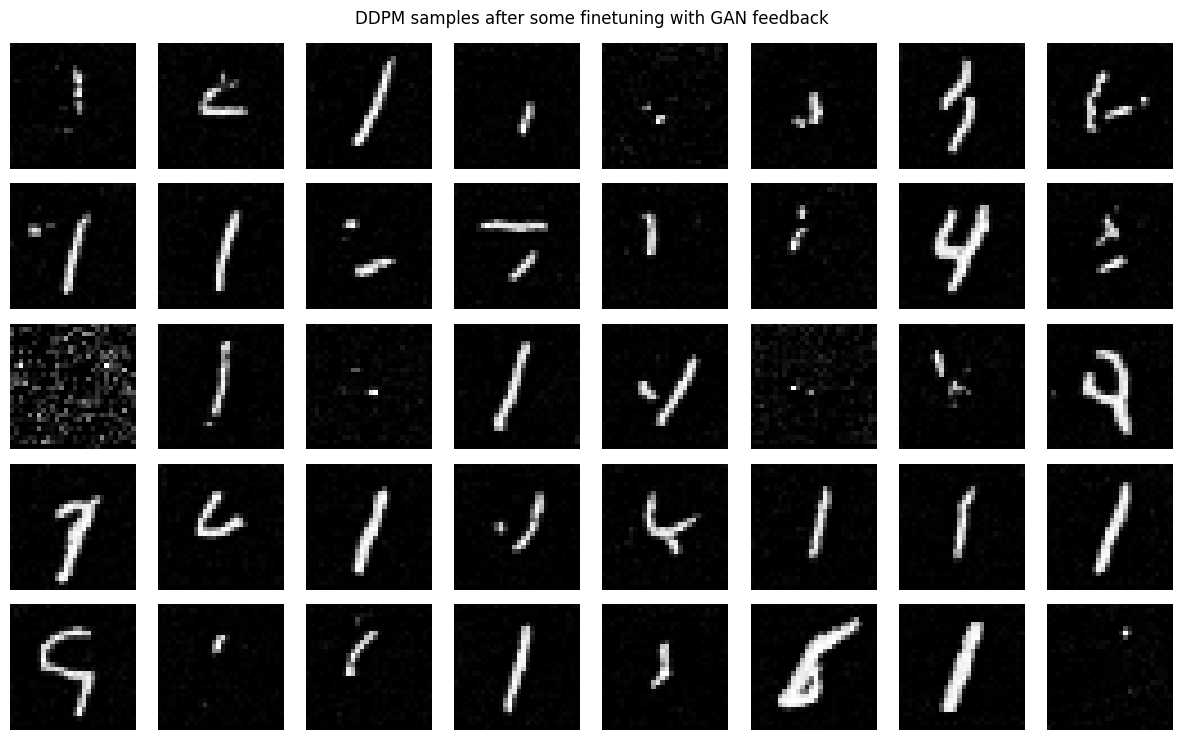

In [ ]:
generate_and_plot_ddpm_samples(
    unet=unet,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=8,
    title="DDPM samples after some finetuning with GAN feedback"
)

In [ ]:
samples = ddpm_sample_batch(
  unet=unet,
  ddpm_schedule=schedule,
  img_wh=(28, 28),
  num_ts=300,
  batch_size=300,
  seed = 1
)

resized_samples = prepare_batch_discr(samples)
mnist = train_dataset
loader = DataLoader(mnist, batch_size=300, shuffle=True)
images, labels = next(iter(loader))
resized_mnist = prepare_batch_discr(images)

real_imgs = resized_mnist.to(device)
fake_imgs = resized_samples.to(device)

with torch.no_grad():
    real_scores = netD(real_imgs)    # expected to be close to 1
    fake_scores = netD(fake_imgs)    # expected to be close to 0

print(f"Average score for real MNIST: {real_scores.mean().item():.4f}")
print(f"Average score for DDPM samples: {fake_scores.mean().item():.4f}")




Average score for real MNIST: 0.6081
Average score for DDPM samples: 0.1648


In [ ]:
torch.save(unet.state_dict(), "unet_ft_noise_20.pth")
from google.colab import files
files.download("unet_ft_noise_20.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Testing with mse loss instead of bce, does not work very well

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

beta_start = 1e-4
beta_end   = 0.02
num_timesteps = 300
batch_size    = 128
epochs        = 5
lr_d          = 1e-4
lr_g          = 1e-5
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

schedule = ddpm_schedule(beta_start, beta_end, num_timesteps)

unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to(device)
unet.load_state_dict(torch.load("unconditioned_unet_5_epochs.pth"))
discriminator = Discriminator(ngpu=1, nc=2, ndf=64).to(device)
discriminator.apply(weights_init)


optD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
optG = optim.Adam(unet.parameters(), lr=lr_g, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

mnist = MNIST(root="./data", train=True, download=True, transform=ToTensor())
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=4)


for epoch in range(epochs):
    for imgs, _ in dataloader:
        imgs = imgs.to(device)

        t = torch.randint(0, num_timesteps, (imgs.size(0),), device=device)
        alpha_bar_t = schedule['alpha_bars'].to(device)[t].view(-1,1,1,1)
        sqrt_ab = torch.sqrt(alpha_bar_t)
        sqrt_1_ab = torch.sqrt(1 - alpha_bar_t)

        noise = torch.randn_like(imgs)
        x_t = sqrt_ab * imgs + sqrt_1_ab * noise

        t_norm = (t.float() / num_timesteps).view(-1,1).to(device)

        for p in unet.parameters():        p.requires_grad_(False)
        for p in discriminator.parameters(): p.requires_grad_(True)
        discriminator.train()
        unet.eval()

        eps_pred = unet(x_t, t_norm)

        fake_d_input = torch.cat([x_t, eps_pred], dim=1)
        real_d_input = torch.cat([x_t, noise], dim=1)

        real_d_input = real_d_input.detach()
        fake_d_input = fake_d_input.detach()

        real_scores = discriminator(real_d_input)
        fake_scores = discriminator(fake_d_input)
        labels_real = torch.ones_like(real_scores)
        labels_fake = torch.zeros_like(fake_scores)

        lossD = mse_loss(real_scores, labels_real) + mse_loss(fake_scores, labels_fake)
        optD.zero_grad()
        lossD.backward()
        optD.step()

        print(f"real scores: {real_scores.mean().item():.4f}, fake scores: {fake_scores.mean().item():.4f}")

        if epoch > 0: #First train only the discriminator for one epoch
          for p in unet.parameters():        p.requires_grad_(True)
          for p in discriminator.parameters(): p.requires_grad_(False)
          unet.train()
          discriminator.train()

          eps_pred = unet(x_t, t_norm)
          fake_d_input = torch.cat([x_t, eps_pred], dim=1)
          gen_scores = discriminator(fake_d_input)
          #testing_scores = discriminator(fake_noise).detach()
          labels_real = torch.ones_like(gen_scores)

          lossG = mse_loss(gen_scores, labels_real)
          optG.zero_grad()
          lossG.backward()
          optG.step()

          print(f"Fake scores from generator after disc update: {gen_scores.mean().item():.4f}")

          del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, eps_pred, real_d_input, fake_d_input, real_scores, fake_scores, labels_real, labels_fake, gen_scores
        else:
          del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, real_d_input, fake_d_input, real_scores, fake_scores, labels_fake



real scores: 0.5953, fake scores: 0.5993
real scores: 0.4765, fake scores: 0.4763
real scores: 0.4521, fake scores: 0.4518
real scores: 0.4671, fake scores: 0.4688
real scores: 0.5230, fake scores: 0.5232
real scores: 0.5095, fake scores: 0.5077
real scores: 0.5047, fake scores: 0.5071
real scores: 0.5150, fake scores: 0.5153
real scores: 0.4979, fake scores: 0.4940
real scores: 0.4816, fake scores: 0.4797
real scores: 0.4844, fake scores: 0.4784
real scores: 0.5168, fake scores: 0.5120
real scores: 0.5080, fake scores: 0.5057
real scores: 0.5101, fake scores: 0.5073
real scores: 0.4915, fake scores: 0.4877
real scores: 0.5150, fake scores: 0.5062
real scores: 0.5030, fake scores: 0.4980
real scores: 0.4907, fake scores: 0.4829
real scores: 0.5089, fake scores: 0.5030
real scores: 0.5039, fake scores: 0.4980
real scores: 0.5078, fake scores: 0.5000
real scores: 0.5312, fake scores: 0.5279
real scores: 0.4583, fake scores: 0.4539
real scores: 0.5033, fake scores: 0.4944
real scores: 0.5

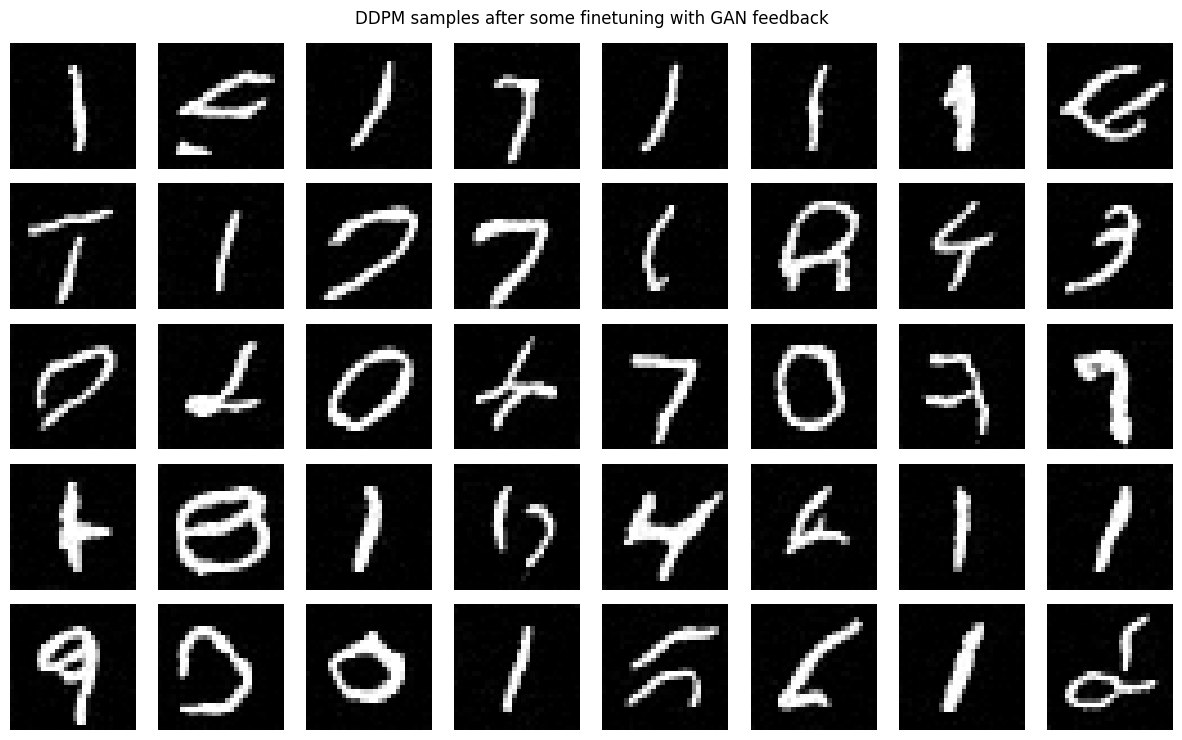

In [ ]:
generate_and_plot_ddpm_samples(
    unet=unet,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=8,
    title="DDPM samples after some finetuning with GAN feedback"
)

In [ ]:
#Tried to alternate the updates, did not work...

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

beta_start = 1e-4
beta_end   = 0.02
num_timesteps = 300
batch_size    = 128
epochs        = 20
lr_d          = 1e-4
lr_g          = 1e-5
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

schedule = ddpm_schedule(beta_start, beta_end, num_timesteps)

unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to(device)
unet.load_state_dict(torch.load("unconditioned_unet_5_epochs.pth"))
discriminator = Discriminator(ngpu=1, nc=1, ndf=64).to(device)
#discriminator.apply(weights_init)


optD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
optG = optim.Adam(unet.parameters(), lr=lr_g, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()

mnist = MNIST(root="./data", train=True, download=True, transform=ToTensor())
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=4)


for epoch in range(epochs):
    i = 0
    for imgs, _ in dataloader:
        i += 1
        imgs = imgs.to(device)

        t = torch.randint(0, num_timesteps, (imgs.size(0),), device=device)
        alpha_bar_t = schedule['alpha_bars'].to(device)[t].view(-1,1,1,1)
        sqrt_ab = torch.sqrt(alpha_bar_t)
        sqrt_1_ab = torch.sqrt(1 - alpha_bar_t)

        noise = torch.randn_like(imgs)
        x_t = sqrt_ab * imgs + sqrt_1_ab * noise

        t_norm = (t.float() / num_timesteps).view(-1,1).to(device)
        if epoch % 2 == 0 or epoch % 3 == 0:
          for p in unet.parameters():        p.requires_grad_(False)
          for p in discriminator.parameters(): p.requires_grad_(True)
          discriminator.train()
          unet.eval()

          eps_pred = unet(x_t, t_norm)

          real_noise = noise.detach()
          fake_noise = eps_pred.detach()

          real_scores = discriminator(real_noise)
          fake_scores = discriminator(fake_noise)
          labels_real = torch.ones_like(real_scores)
          labels_fake = torch.zeros_like(fake_scores)

          lossD = bce_loss(real_scores, labels_real) + bce_loss(fake_scores, labels_fake)
          optD.zero_grad()
          lossD.backward()
          optD.step()

          if i % 10 == 0:
            print(f"real scores: {real_scores.mean().item():.4f}, fake scores: {fake_scores.mean().item():.4f}")
        else:
          if epoch > -1: #First train only the discriminator for one epoch
            for p in unet.parameters():        p.requires_grad_(True)
            for p in discriminator.parameters(): p.requires_grad_(False)
            unet.train()

            eps_pred = unet(x_t, t_norm)
            gen_scores = discriminator(eps_pred)
            labels_real = torch.ones_like(gen_scores)

            lossG = bce_loss(gen_scores, labels_real)
            optG.zero_grad()
            lossG.backward()
            optG.step()
            if i % 10 == 0:
              print(f"Fake scores after disc update: {gen_scores.mean().item():.4f}")

real scores: 0.5030, fake scores: 0.4901
real scores: 0.5141, fake scores: 0.4829
real scores: 0.5327, fake scores: 0.5005
real scores: 0.5565, fake scores: 0.5006
real scores: 0.5353, fake scores: 0.4693
real scores: 0.5663, fake scores: 0.4821
real scores: 0.5141, fake scores: 0.4321
real scores: 0.5604, fake scores: 0.4635
real scores: 0.5858, fake scores: 0.4733
real scores: 0.5660, fake scores: 0.4576
real scores: 0.5852, fake scores: 0.4499
real scores: 0.5859, fake scores: 0.4309
real scores: 0.5416, fake scores: 0.4154
real scores: 0.5753, fake scores: 0.4169
real scores: 0.5598, fake scores: 0.3851
real scores: 0.5599, fake scores: 0.3723
real scores: 0.5700, fake scores: 0.3535
real scores: 0.6728, fake scores: 0.4501
real scores: 0.6871, fake scores: 0.5044
real scores: 0.4555, fake scores: 0.2641
real scores: 0.5347, fake scores: 0.3421
real scores: 0.6437, fake scores: 0.4067
real scores: 0.6035, fake scores: 0.3397
real scores: 0.6884, fake scores: 0.4112
real scores: 0.6

KeyboardInterrupt: 

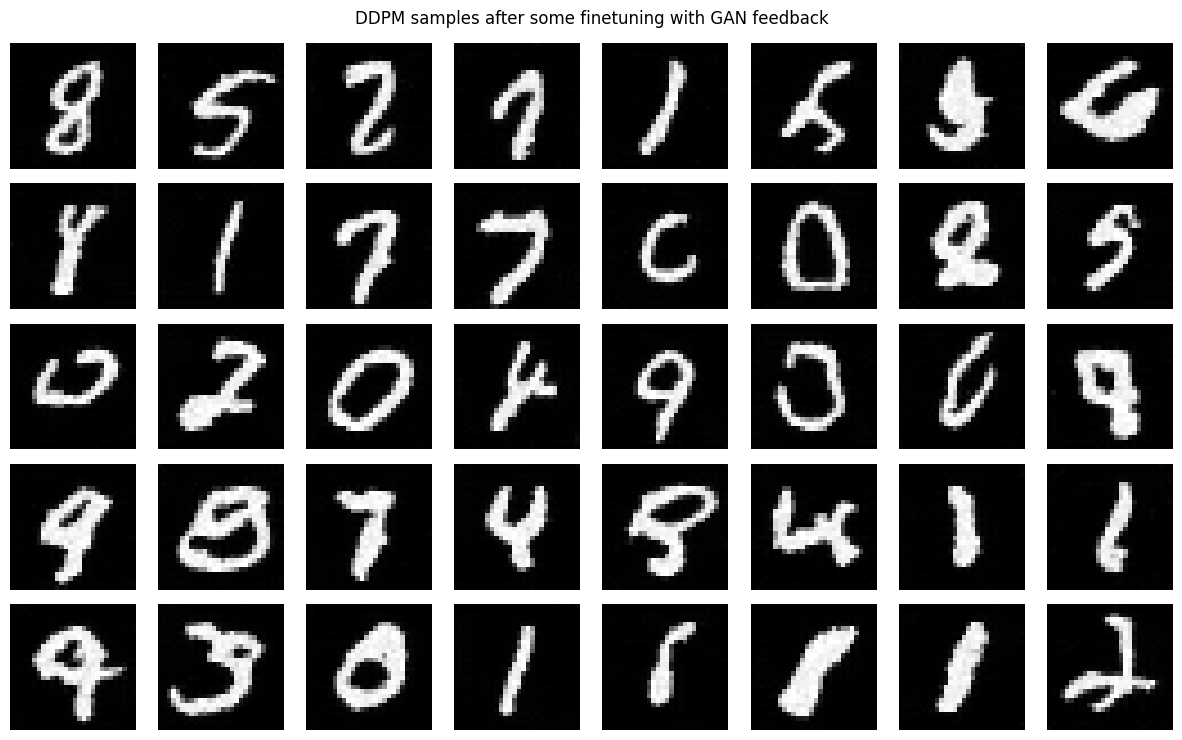

In [ ]:
generate_and_plot_ddpm_samples(
    unet=unet,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=8,
    title="DDPM samples after some finetuning with GAN feedback"
)

### Fine-tune diffusion model, train discriminator from scratch, both on noise, with time-conditioned discriminator

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

beta_start = 1e-4
beta_end   = 0.02
num_timesteps = 300
batch_size    = 128
epochs        = 20
lr_d          = 1e-4
lr_g          = 1e-5
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

schedule = ddpm_schedule(beta_start, beta_end, num_timesteps)

unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to(device)
unet.load_state_dict(torch.load("unconditioned_unet_5_epochs.pth"))
discriminator = TimeConditionedDiscriminator(ngpu=1, nc=1, ndf=64).to(device)
discriminator.apply(weights_init)


optD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
optG = optim.Adam(unet.parameters(), lr=lr_g, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()

mnist = MNIST(root="./data", train=True, download=True, transform=ToTensor())
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=4)


for epoch in range(epochs):
    i = 0
    for imgs, _ in dataloader:
        i += 1
        imgs = imgs.to(device)

        t = torch.randint(0, num_timesteps, (imgs.size(0),), device=device)
        alpha_bar_t = schedule['alpha_bars'].to(device)[t].view(-1,1,1,1)
        sqrt_ab = torch.sqrt(alpha_bar_t)
        sqrt_1_ab = torch.sqrt(1 - alpha_bar_t)

        noise = torch.randn_like(imgs)
        x_t = sqrt_ab * imgs + sqrt_1_ab * noise

        t_norm = (t.float() / num_timesteps).view(-1,1).to(device)

        for p in unet.parameters():        p.requires_grad_(False)
        for p in discriminator.parameters(): p.requires_grad_(True)
        discriminator.train()
        unet.eval()

        eps_pred = unet(x_t, t_norm)

        real_noise = noise.detach()
        fake_noise = eps_pred.detach()

        real_scores = discriminator(real_noise, t_norm)
        fake_scores = discriminator(fake_noise, t_norm)
        labels_real = torch.ones_like(real_scores)
        labels_fake = torch.zeros_like(fake_scores)

        lossD = bce_loss(real_scores, labels_real) + bce_loss(fake_scores, labels_fake)
        optD.zero_grad()
        lossD.backward()
        optD.step()
        if i % 10 == 0:
          print(f"real scores: {real_scores.mean().item():.4f}, fake scores: {fake_scores.mean().item():.4f}")

        if epoch > 0: #First train only the discriminator for one epoch
          for p in unet.parameters():        p.requires_grad_(True)
          for p in discriminator.parameters(): p.requires_grad_(False)
          unet.train()
          discriminator.train()

          eps_pred = unet(x_t, t_norm)
          gen_scores = discriminator(eps_pred, t_norm)
          labels_real = torch.ones_like(gen_scores)

          lossG = bce_loss(gen_scores, labels_real)
          optG.zero_grad()
          lossG.backward()
          optG.step()

          if i % 10 == 0:
            print(f"Fake scores from generator after disc update: {gen_scores.mean().item():.4f}")

          del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, eps_pred, real_noise, fake_noise, real_scores, fake_scores, labels_real, labels_fake, gen_scores
        else:
          del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, real_noise, fake_noise, real_scores, fake_scores, labels_fake



real scores: 0.5091, fake scores: 0.5054
real scores: 0.5182, fake scores: 0.4997
real scores: 0.5299, fake scores: 0.5072
real scores: 0.5290, fake scores: 0.4900
real scores: 0.5148, fake scores: 0.4682
real scores: 0.5547, fake scores: 0.4842
real scores: 0.5629, fake scores: 0.4693
real scores: 0.5405, fake scores: 0.4396
real scores: 0.5758, fake scores: 0.4435
real scores: 0.5949, fake scores: 0.4327
real scores: 0.6234, fake scores: 0.4470
real scores: 0.6139, fake scores: 0.3992
real scores: 0.5583, fake scores: 0.3475
real scores: 0.6739, fake scores: 0.4409
real scores: 0.6728, fake scores: 0.4046
real scores: 0.5916, fake scores: 0.3022
real scores: 0.5500, fake scores: 0.2535
real scores: 0.6708, fake scores: 0.3173
real scores: 0.6043, fake scores: 0.2521
real scores: 0.8369, fake scores: 0.5308
real scores: 0.8269, fake scores: 0.4815
real scores: 0.6173, fake scores: 0.2568
real scores: 0.5968, fake scores: 0.1808
real scores: 0.7388, fake scores: 0.2919
real scores: 0.7

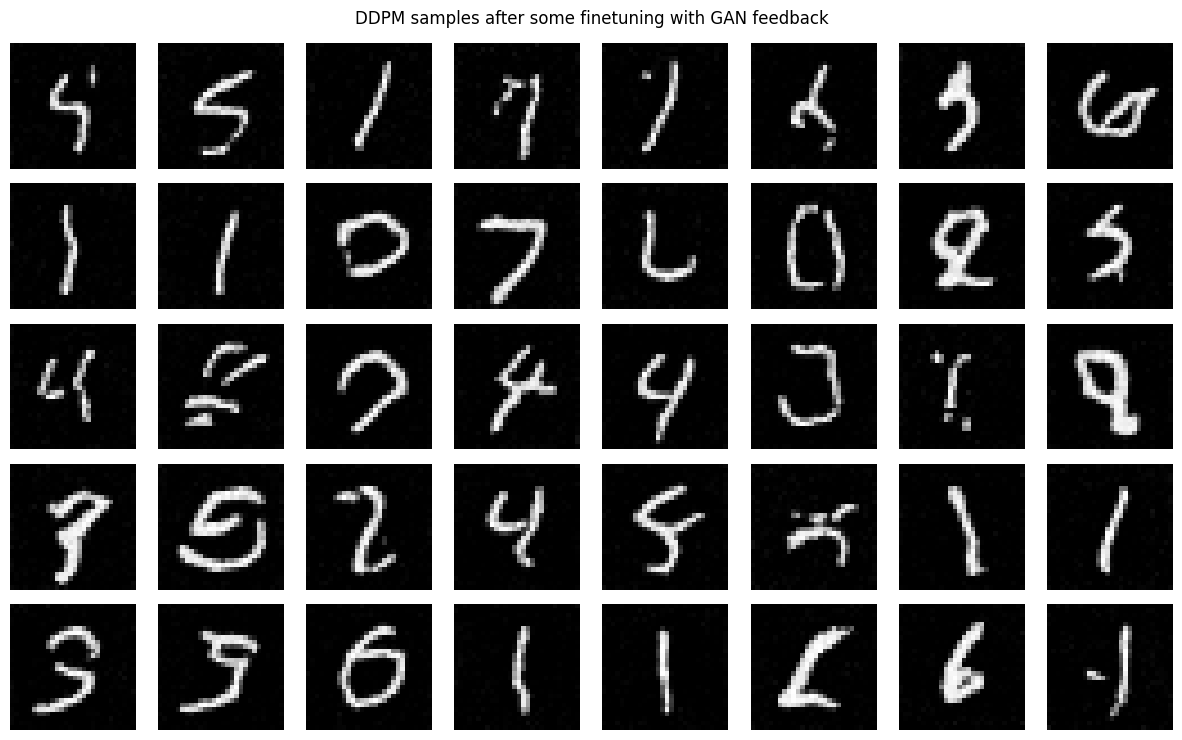

In [ ]:
generate_and_plot_ddpm_samples(
    unet=unet,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=8,
    title="DDPM samples after some finetuning with GAN feedback"
)

In [ ]:
samples = ddpm_sample_batch(
  unet=unet,
  ddpm_schedule=schedule,
  img_wh=(28, 28),
  num_ts=300,
  batch_size=300,
  seed = 1
)

resized_samples = prepare_batch_discr(samples)
mnist = train_dataset
loader = DataLoader(mnist, batch_size=300, shuffle=True)
images, labels = next(iter(loader))
resized_mnist = prepare_batch_discr(images)

real_imgs = resized_mnist.to(device)
fake_imgs = resized_samples.to(device)

with torch.no_grad():
    real_scores = netD(real_imgs)    # expected to be close to 1
    fake_scores = netD(fake_imgs)    # expected to be close to 0

print(f"Average score for real MNIST: {real_scores.mean().item():.4f}")
print(f"Average score for DDPM samples: {fake_scores.mean().item():.4f}")

torch.save(unet.state_dict(), "unet_ft_noise_time_cond_20.pth")
from google.colab import files
files.download("unet_ft_noise_time_cond_20.pth")


Average score for real MNIST: 0.6081
Average score for DDPM samples: 0.1709


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Adding both noise and noisy version of image as input to the discriminator + time condition

In [ ]:
import torch
import torch.nn as nn
import urllib.request

# --- Define the architecture ---
class TimeConditionedDiscriminatorTwoInputs(nn.Module):
    def __init__(self, ngpu, nc=1, ndf=64):
        super(TimeConditionedDiscriminatorTwoInputs, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc+2, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, x_t, t):
        B, _, H, W = x.shape
        t = t.view(B, 1, 1, 1).expand(B, 1, H, W)
        x_combined = torch.cat([x, x_t, t], dim=1)
        return self.main(x_combined).view(-1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

beta_start = 1e-4
beta_end   = 0.02
num_timesteps = 300
batch_size    = 128
epochs        = 20
lr_d          = 1e-4
lr_g          = 1e-5
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

schedule = ddpm_schedule(beta_start, beta_end, num_timesteps)

unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to(device)
unet.load_state_dict(torch.load("unconditioned_unet_5_epochs.pth"))
discriminator = TimeConditionedDiscriminatorTwoInputs(ngpu=1, nc=1, ndf=64).to(device)
#discriminator.apply(weights_init)


optD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
optG = optim.Adam(unet.parameters(), lr=lr_g, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()

mnist = MNIST(root="./data", train=True, download=True, transform=ToTensor())
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=4)


for epoch in range(epochs):
    i = 0
    for imgs, _ in dataloader:
        i += 1
        imgs = imgs.to(device)

        t = torch.randint(0, num_timesteps, (imgs.size(0),), device=device)
        alpha_bar_t = schedule['alpha_bars'].to(device)[t].view(-1,1,1,1)
        sqrt_ab = torch.sqrt(alpha_bar_t)
        sqrt_1_ab = torch.sqrt(1 - alpha_bar_t)

        noise = torch.randn_like(imgs)
        x_t = sqrt_ab * imgs + sqrt_1_ab * noise

        t_norm = (t.float() / num_timesteps).view(-1,1).to(device)

        for p in unet.parameters():        p.requires_grad_(False)
        for p in discriminator.parameters(): p.requires_grad_(True)
        discriminator.train()
        unet.eval()

        eps_pred = unet(x_t, t_norm)

        real_noise = noise.detach()
        fake_noise = eps_pred.detach()

        real_scores = discriminator(real_noise, x_t, t_norm)
        fake_scores = discriminator(fake_noise, x_t, t_norm)
        labels_real = torch.ones_like(real_scores)
        labels_fake = torch.zeros_like(fake_scores)

        lossD = bce_loss(real_scores, labels_real) + bce_loss(fake_scores, labels_fake)
        optD.zero_grad()
        lossD.backward()
        optD.step()
        if i % 10 == 0:
          print(f"real scores: {real_scores.mean().item():.4f}, fake scores: {fake_scores.mean().item():.4f}")

        if epoch > 0: #First train only the discriminator for one epoch
          for p in unet.parameters():        p.requires_grad_(True)
          for p in discriminator.parameters(): p.requires_grad_(False)
          unet.train()
          discriminator.train()

          eps_pred = unet(x_t, t_norm)
          gen_scores = discriminator(eps_pred, x_t, t_norm)
          labels_real = torch.ones_like(gen_scores)

          lossG = bce_loss(gen_scores, labels_real)
          optG.zero_grad()
          lossG.backward()
          optG.step()

          if i % 10 == 0:
            print(f"Fake scores from generator after disc update: {gen_scores.mean().item():.4f}")

          del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, eps_pred, real_noise, fake_noise, real_scores, fake_scores, labels_real, labels_fake, gen_scores
        else:
          del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, real_noise, fake_noise, real_scores, fake_scores, labels_fake



real scores: 0.4997, fake scores: 0.4965
real scores: 0.4913, fake scores: 0.4807
real scores: 0.5145, fake scores: 0.4987
real scores: 0.5022, fake scores: 0.4771
real scores: 0.5396, fake scores: 0.5029
real scores: 0.5098, fake scores: 0.4571
real scores: 0.5497, fake scores: 0.4822
real scores: 0.5462, fake scores: 0.4656
real scores: 0.4778, fake scores: 0.3908
real scores: 0.5076, fake scores: 0.3985
real scores: 0.4979, fake scores: 0.3814
real scores: 0.6313, fake scores: 0.5167
real scores: 0.6380, fake scores: 0.4694
real scores: 0.5037, fake scores: 0.3368
real scores: 0.7312, fake scores: 0.5012
real scores: 0.6539, fake scores: 0.4440
real scores: 0.6754, fake scores: 0.3696
real scores: 0.7232, fake scores: 0.4590
real scores: 0.5428, fake scores: 0.2983
real scores: 0.6101, fake scores: 0.2842
real scores: 0.5561, fake scores: 0.2438
real scores: 0.8219, fake scores: 0.5281
real scores: 0.5831, fake scores: 0.2504
real scores: 0.5909, fake scores: 0.2332
real scores: 0.7

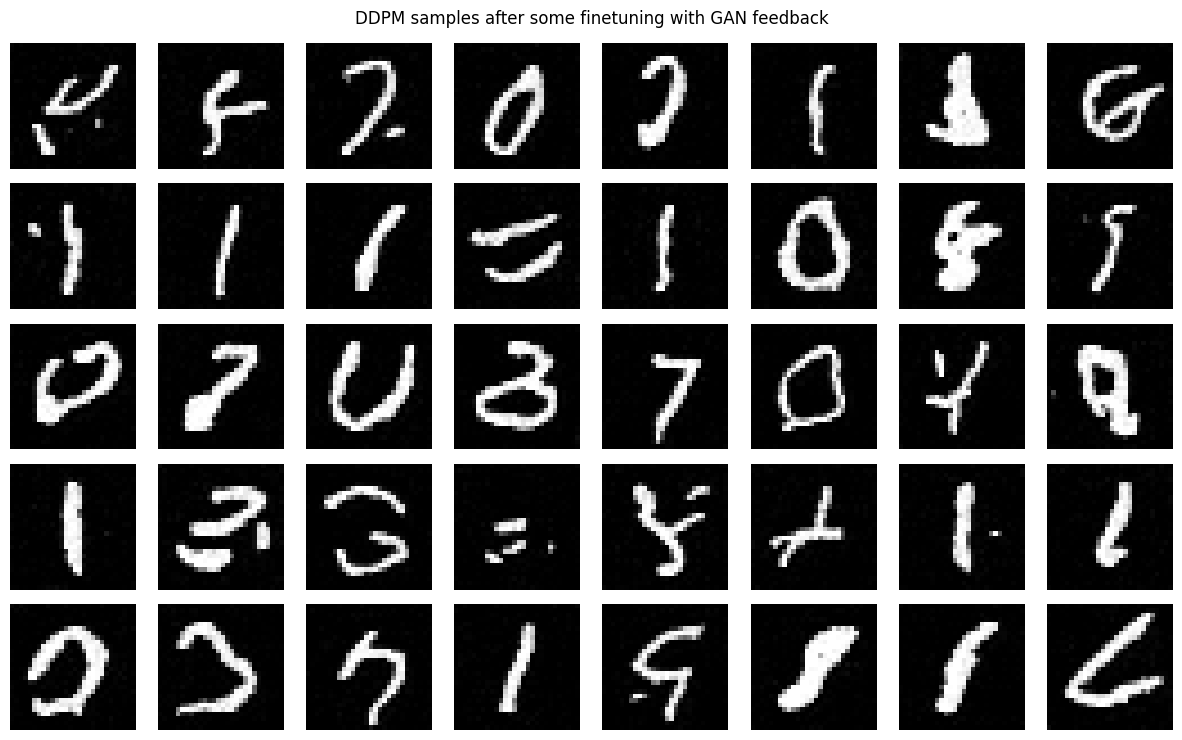

In [ ]:
generate_and_plot_ddpm_samples(
    unet=unet,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=8,
    title="DDPM samples after some finetuning with GAN feedback"
)

### Fine-tune diffusion model, train discriminator from scratch, both on the next image in the schedule

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

beta_start = 1e-4
beta_end   = 0.02
num_timesteps = 300
batch_size    = 128
epochs        = 10
lr_d          = 1e-4
lr_g          = 1e-5
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

schedule = ddpm_schedule(beta_start, beta_end, num_timesteps)

unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to(device)
unet.load_state_dict(torch.load("unconditioned_unet_5_epochs.pth"))
discriminator = Discriminator(ngpu=1, nc=1, ndf=64).to(device)
discriminator.apply(weights_init)


optD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
optG = optim.Adam(unet.parameters(), lr=lr_g, betas=(0.5, 0.999))
bce_loss = nn.BCELoss()
mse_loss=nn.MSELoss()

mnist = MNIST(root="./data", train=True, download=True, transform=ToTensor())
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=4)


for epoch in range(epochs):
    i = 0
    for imgs, _ in dataloader:
        i += 1
        imgs = imgs.to(device)

        t = torch.randint(0, num_timesteps, (imgs.size(0),), device=device)
        alpha_t = schedule['alphas'].to(device)[t].view(-1, 1, 1, 1)
        beta_t = schedule['betas'].to(device)[t].view(-1, 1, 1, 1)
        alpha_bar_t = schedule['alpha_bars'].to(device)[t].view(-1,1,1,1)
        sqrt_ab = torch.sqrt(alpha_bar_t)
        sqrt_1_ab = torch.sqrt(1 - alpha_bar_t)

        sqrt_recip_alpha_t = torch.sqrt(1.0 / alpha_t)
        posterior_variance = beta_t

        noise = torch.randn_like(imgs)

        x_t = sqrt_ab * imgs + sqrt_1_ab * noise

        t_norm = (t.float() / num_timesteps).view(-1,1).to(device)
        if epoch %5 == 0:
          for p in unet.parameters():        p.requires_grad_(False)
          for p in discriminator.parameters(): p.requires_grad_(True)
          discriminator.train()
          unet.eval()
          z = torch.randn_like(x_t)
          x_prev_real = sqrt_recip_alpha_t * (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * noise) + torch.sqrt(posterior_variance) * z
          eps_pred = unet(x_t, t_norm)
          x_prev_fake = sqrt_recip_alpha_t * (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * eps_pred) + torch.sqrt(posterior_variance) * z

          x_prev_real = x_prev_real.detach()
          x_prev_fake = x_prev_fake.detach()

          real_scores = discriminator(x_prev_real)
          fake_scores = discriminator(x_prev_fake)
          labels_real = torch.ones_like(real_scores)
          labels_fake = torch.zeros_like(fake_scores)

          lossD = bce_loss(real_scores, labels_real) + bce_loss(fake_scores, labels_fake)
          optD.zero_grad()
          lossD.backward()
          optD.step()
        if i % 10 == 0:
          print(f"real scores: {real_scores.mean().item():.4f}, fake scores: {fake_scores.mean().item():.4f}")

        if epoch > -1: #First train only the discriminator for one epoch
          for p in unet.parameters():        p.requires_grad_(True)
          for p in discriminator.parameters(): p.requires_grad_(False)
          unet.train()
          discriminator.train()

          eps_pred = unet(x_t, t_norm)
          x_prev_fake = sqrt_recip_alpha_t * (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * eps_pred) + torch.sqrt(posterior_variance) * z
          gen_scores = discriminator(x_prev_fake)
          labels_real = torch.ones_like(gen_scores)

          lossG = bce_loss(gen_scores, labels_real)
          optG.zero_grad()
          lossG.backward()
          optG.step()
          if i % 10 == 0:
            print(f"Fake scores from generator after disc update: {gen_scores.mean().item():.4f}")

            del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, eps_pred, x_prev_real, x_prev_fake, real_scores, fake_scores, labels_real, labels_fake, gen_scores
          else:
            del imgs, t, alpha_bar_t, sqrt_ab, sqrt_1_ab, noise, x_t, t_norm, x_prev_real, x_prev_fake, real_scores, fake_scores, labels_fake



real scores: 0.5235, fake scores: 0.4088
Fake scores from generator after disc update: 0.4469
real scores: 0.5776, fake scores: 0.4817
Fake scores from generator after disc update: 0.4523
real scores: 0.4753, fake scores: 0.3868
Fake scores from generator after disc update: 0.5140
real scores: 0.5805, fake scores: 0.4386
Fake scores from generator after disc update: 0.4306
real scores: 0.6059, fake scores: 0.4120
Fake scores from generator after disc update: 0.4217
real scores: 0.6106, fake scores: 0.4090
Fake scores from generator after disc update: 0.4013
real scores: 0.7119, fake scores: 0.4866
Fake scores from generator after disc update: 0.2159
real scores: 0.5478, fake scores: 0.3064
Fake scores from generator after disc update: 0.4171
real scores: 0.6334, fake scores: 0.3626
Fake scores from generator after disc update: 0.3700
real scores: 0.6841, fake scores: 0.4058
Fake scores from generator after disc update: 0.3561
real scores: 0.6764, fake scores: 0.3758
Fake scores from ge

KeyboardInterrupt: 

In [ ]:
samples = ddpm_sample_batch(
  unet=unet,
  ddpm_schedule=schedule,
  img_wh=(28, 28),
  num_ts=300,
  batch_size=300,
  seed = 1
)

resized_samples = prepare_batch_discr(samples)
mnist = train_dataset
loader = DataLoader(mnist, batch_size=300, shuffle=True)
images, labels = next(iter(loader))
resized_mnist = prepare_batch_discr(images)

real_imgs = resized_mnist.to(device)
fake_imgs = resized_samples.to(device)

with torch.no_grad():
    real_scores = netD(real_imgs)    # expected to be close to 1
    fake_scores = netD(fake_imgs)    # expected to be close to 0

print(f"Average score for real MNIST: {real_scores.mean().item():.4f}")
print(f"Average score for DDPM samples: {fake_scores.mean().item():.4f}")


Average score for real MNIST: 0.6081
Average score for DDPM samples: 0.0515


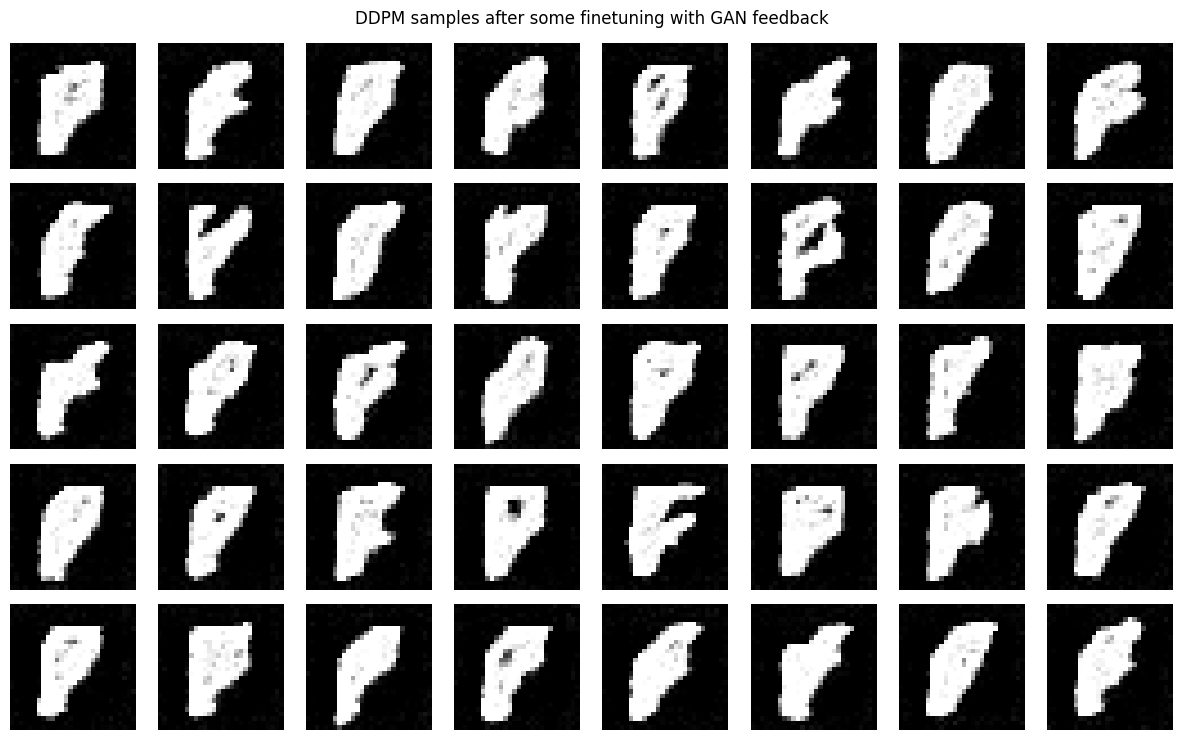

In [ ]:
generate_and_plot_ddpm_samples(
    unet=unet,
    ddpm_schedule=schedule,
    img_wh=(28, 28),
    num_ts=300,
    seed=0,
    batch_size=40,
    num_cols=8,
    title="DDPM samples after some finetuning with GAN feedback"
)